In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jcopml.plot import plot_missing_value #untuk plot missing value
from sklearn.model_selection import train_test_split #untuk dataset splitting

#library untuk preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier, plot_importance, plot_tree #untuk pemodelan dan plotting
from sklearn.linear_model import LogisticRegression

#library untuk model training
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.utils import Integer, Real
from jcopml.tuning.space import Integer as JInteger, Real as JReal

from jcopml.utils import save_model #save model


# Import Data

In [2]:
#Import Data
df=pd.read_csv("hmeq.csv",sep=',')
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [4]:
print(df.nunique())

BAD           2
LOAN        540
MORTDUE    5053
VALUE      5381
REASON        2
JOB           6
YOJ          99
DEROG        11
DELINQ       14
CLAGE      5314
NINQ         16
CLNO         62
DEBTINC    4693
dtype: int64


In [5]:
df['BAD']=pd.Categorical(df.BAD)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   BAD      5960 non-null   category
 1   LOAN     5960 non-null   int64   
 2   MORTDUE  5442 non-null   float64 
 3   VALUE    5848 non-null   float64 
 4   REASON   5708 non-null   object  
 5   JOB      5681 non-null   object  
 6   YOJ      5445 non-null   float64 
 7   DEROG    5252 non-null   float64 
 8   DELINQ   5380 non-null   float64 
 9   CLAGE    5652 non-null   float64 
 10  NINQ     5450 non-null   float64 
 11  CLNO     5738 non-null   float64 
 12  DEBTINC  4693 non-null   float64 
dtypes: category(1), float64(9), int64(1), object(2)
memory usage: 564.8+ KB


In [6]:
df.describe()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


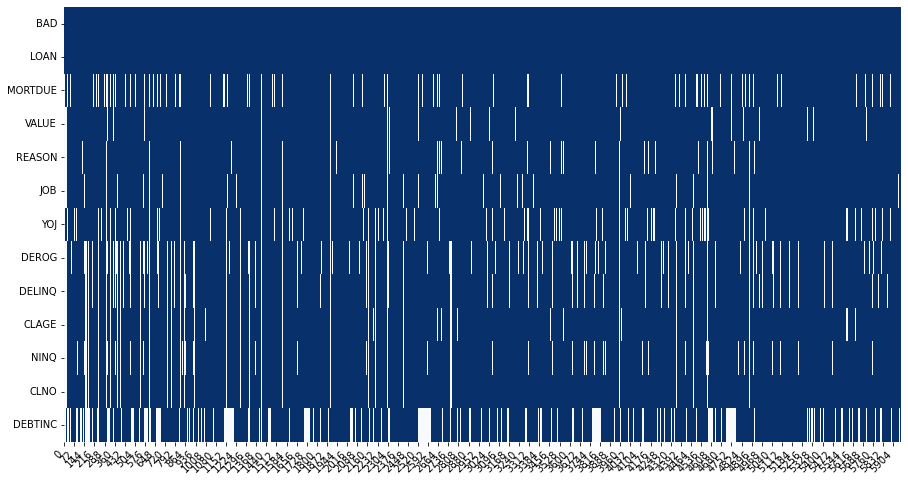

In [7]:
plot_missing_value(df)

0    4771
1    1189
Name: BAD, dtype: int64

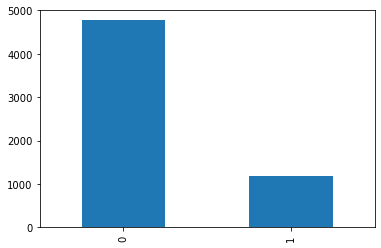

In [8]:
df.BAD.value_counts().plot(kind="bar")
df.BAD.value_counts()

# Dataset Splitting

In [9]:
# dataset splitting
X = df.drop(columns="BAD")
y = df.BAD

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4768, 12), (1192, 12), (4768,), (1192,))

# Step 1: Data Preprocessing

In [10]:
num_data=X_train.select_dtypes(include=[np.number])
cat_data=X_train.select_dtypes(exclude=[np.number])
num_columns=num_data.columns
cat_columns=cat_data.columns

# Preprocessor
numerical_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
categorical_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor=ColumnTransformer(transformers=[
    ('numeric', numerical_pipeline, num_columns),
    ('categoric', categorical_pipeline, cat_columns)
])

In [11]:
#Pipeline XGB
ratio=float((np.sum(df.BAD == 0)) / (np.sum(df.BAD==1)))
pipeline=Pipeline([
    ('prepo', preprocessor),
    ('algo', XGBClassifier(random_state=23, scale_pos_weight=ratio))
])

# Step 2: Model Training

In [12]:
## Model Default XGB
# Waktu Running
start = time.time()
columns_names=X_train.columns
model_d=pipeline.fit(X_train, y_train)
end = time.time() 

waktu_md=end-start
print(f"Best Score : {cross_val_score(model_d,X_train, y_train, scoring='f1', cv=3).mean(), cross_val_score(model_d,X_test, y_test,scoring='f1', cv=3).mean()}")
print(f"Waktu Running : {waktu_md}")

#Fitting Model
y_pred_md=model_d.predict(X_test)
cm_md=confusion_matrix(y_test, y_pred_md)
print(f"\n Confussion Matrix Model Default:\n {cm_md}")

# Performa Model
tn, fp, fn, tp =cm_md.ravel()
accuracy_md=(tn+tp)/(tn+fp+fn+tp)
sensitivity_md=tp/(tp+fn)
precition_md=tp/(tp+fp)
specificity_md=tn/(tn+fp)
f1score_md=2*tp/(2*tp+fp+fn)
print("\n Performa Model Default")
print("Accuracy :", accuracy_md)
print("Sensitivity :", sensitivity_md)
print("Precition :", precition_md)
print("Specificity :", specificity_md)
print("F1 Score :", f1score_md)

Best Score : (0.7199026941456189, 0.6887254599048157)
Waktu Running : 0.6277275085449219

 Confussion Matrix Model Default:
 [[874  80]
 [ 49 189]]

 Performa Model Default
Accuracy : 0.8917785234899329
Sensitivity : 0.7941176470588235
Precition : 0.7026022304832714
Specificity : 0.9161425576519916
F1 Score : 0.7455621301775148


### GridSearchCV

In [13]:
grid_params={
    'algo__max_depth': [4, 6, 8],
    'algo__colsample_bytree': [0.9, 1.0],
    'algo__n_estimators': [80, 100, 160],
    'algo__subsample': [0.9, 1.0],
    'algo__gamma': [0.01, 0.1],
    'algo__learning_rate': [0.01, 0.1, 0.2],
    'algo__min_child_weight': [0.0, 3.0]
}

In [58]:
## Model GSCV XGB
#Waktu Penyetelan
start=time.time()
model_gsCV = GridSearchCV(pipeline, grid_params, cv=3,scoring='f1', verbose=1, n_jobs=-1)
model_gsCV.fit(X_train, y_train)
end=time.time()

waktu_mg=end-start
print(f"Best Parameter: {model_gsCV.best_params_}")
print(f" Score Train dan Test: {model_gsCV.score(X_train, y_train), model_gsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mg}")

#Fitting Model
y_pred_mg=model_gsCV.predict(X_test)
cm_mg=confusion_matrix(y_test, y_pred_mg)
print(f"\n Confussion Matrix Model Grid Search:\n {cm_mg}")

# Performa Model
tn, fp, fn, tp=cm_mg.ravel()
accuracy_mg=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mg=tp/(tp+fn)
precition_mg=tp/(tp+fp)
specificity_mg=tn/(tn+fp)
f1score_mg=2*tp/(2*tp+fp+fn)
print("\n Performa Model Grid Search")
print("Accuracy :", accuracy_mg)
print("Sensitivity :", sensitivity_mg)
print("Precition :", precition_mg)
print("Specificity :", specificity_mg)
print("F1 Score :", f1score_mg)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Parameter: {'algo__colsample_bytree': 0.9, 'algo__gamma': 0.1, 'algo__learning_rate': 0.2, 'algo__max_depth': 8, 'algo__min_child_weight': 0.0, 'algo__n_estimators': 160, 'algo__subsample': 0.9}
 Score Train dan Test: (1.0, 0.8453159041394336)
Waktu Running : 290.6064488887787

 Confussion Matrix Model Grid Search:
 [[927  27]
 [ 44 194]]

 Performa Model Grid Search
Accuracy : 0.9404362416107382
Sensitivity : 0.8151260504201681
Precition : 0.8778280542986425
Specificity : 0.9716981132075472
F1 Score : 0.8453159041394336


### RandomizedSearchCV

In [18]:
random_params={
    'algo__max_depth': JInteger(low=3, high=10),
    'algo__learning_rate': JReal(low=0.01, high=0.3, prior='uniform'),
    'algo__n_estimators': JInteger(low=30, high=180),
    'algo__subsample': JReal(low=0.9, high=1.0, prior='uniform'),
    'algo__gamma': JReal(low=0.01, high=0.1, prior='uniform'),
    'algo__colsample_bytree': JReal(low=0.9, high=1.0, prior='uniform'),
    'algo__min_child_weight': JReal(low=0.0, high=5.0, prior='uniform')
}

In [19]:
## Model RSCV XGB
# Waktu Penyetelan
start=time.time()
model_rsCV = RandomizedSearchCV(pipeline, random_params,scoring='f1', cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=23)
model_rsCV.fit(X_train, y_train)
end=time.time()

waktu_mr=end-start
print(f"Best Parameter: {model_rsCV.best_params_}")
print(f" Score Train dan Test: {model_rsCV.score(X_train, y_train), model_rsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mr}")

#Fitting Model
y_pred_mr=model_rsCV.predict(X_test)
cm_mr=confusion_matrix(y_test, y_pred_mr)
print(f"\n Confussion Matrix Model Random Search:\n {cm_mr}")

# Performa Model
tn, fp, fn, tp=cm_mr.ravel()
accuracy_mr=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mr=tp/(tp+fn)
precition_mr=tp/(tp+fp)
specificity_mr=tn/(tn+fp)
f1score_mr=2*tp/(2*tp+fp+fn)
print("\n Performa Model Random Search")
print("Accuracy :", accuracy_mr)
print("Sensitivity :", sensitivity_mr)
print("Precition :", precition_mr)
print("Specificity :", specificity_mr)
print("F1 Score :", f1score_mr)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameter: {'algo__colsample_bytree': 0.9479573941398162, 'algo__gamma': 0.045184631544027284, 'algo__learning_rate': 0.20347697624592884, 'algo__max_depth': 6, 'algo__min_child_weight': 0.002644055846380278, 'algo__n_estimators': 148, 'algo__subsample': 0.9172184110742068}
 Score Train dan Test: (0.9984251968503937, 0.8347826086956522)
Waktu Running : 61.19289565086365

 Confussion Matrix Model Random Search:
 [[924  30]
 [ 46 192]]

 Performa Model Random Search
Accuracy : 0.9362416107382551
Sensitivity : 0.8067226890756303
Precition : 0.8648648648648649
Specificity : 0.9685534591194969
F1 Score : 0.8347826086956521


### BayesianSearchCV

In [13]:
bayes_params={
    'algo__max_depth': Integer(low=3, high=10),
    'algo__learning_rate': Real(low=0.01, high=0.3, prior='uniform'),
    'algo__n_estimators': Integer(low=30, high=180),
    'algo__subsample': Real(low=0.9, high=1.0, prior='uniform'),
    'algo__gamma': Real(low=0.01, high=0.1, prior='uniform'),
    'algo__colsample_bytree': Real(low=0.9, high=1.0, prior='uniform'),
    'algo__min_child_weight': Real(low=0.0, high=5.0, prior='uniform')
}

In [14]:
## Model BSCV XGB
# Waktu Penyetelan
start=time.time()
model_bsCV = BayesSearchCV(pipeline, bayes_params, optimizer_kwargs={'n_initial_points': 5, 'acq_func': 'EI'}, cv=3,scoring='f1', verbose=1, n_iter=50, n_jobs=-1, random_state=23)
model_bsCV.fit(X_train, y_train)
end=time.time()

waktu_mb=end-start
print(f"Best Parameter: {model_bsCV.best_params_}")
print(f" Score Train dan Test: {model_bsCV.score(X_train, y_train), model_bsCV.score(X_test, y_test)}")
print(f"Waktu Running : {waktu_mb}")

#Fitting Model
y_pred_mb=model_bsCV.predict(X_test)
cm_mb=confusion_matrix(y_test, y_pred_mb)
print(f"\n Confussion Matrix Model Bayesian Search:\n {cm_mb}")

# Performa Model
tn, fp, fn, tp=cm_mb.ravel()
accuracy_mb=(tn+tp)/(tn+fp+fn+tp)
sensitivity_mb=tp/(tp+fn)
precition_mb=tp/(tp+fp)
specificity_mb=tn/(tn+fp)
f1score_mb=2*tp/(2*tp+fp+fn)
print("\n Performa Model Bayesian Search")
print("Accuracy :", accuracy_mb)
print("Sensitivity :", sensitivity_mb)
print("Precition :", precition_mb)
print("Specificity :", specificity_mb)
print("F1 Score :", f1score_mb)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [33]:
df_pred=pd.DataFrame({'Data Asli':y_test,
             'Hasil Prediksi': y_pred_mb})
df_pred.to_csv(r'D:\TUGAS AKHIR\Syntax\HMEQprestesting.csv', header=True)

In [24]:
y_test.value_counts()

0    954
1    238
Name: BAD, dtype: int64

In [37]:
y_pred_mb_df=pd.DataFrame(y_pred_mb)
y_pred_mb_df.value_counts()

0    965
1    227
dtype: int64

# Step 3: Evaluasi

In [59]:
acc= [accuracy_md, accuracy_mg, accuracy_mr, accuracy_mb] 
sens=[sensitivity_md, sensitivity_mg, sensitivity_mr,sensitivity_mb]
prec=[precition_md, precition_mg,  precition_mr,  precition_mb]
spec=[specificity_md,  specificity_mg, specificity_mr,  specificity_mb]
f1s=[f1score_md,  f1score_mg,  f1score_mr, f1score_mb]
wkt=[waktu_md, waktu_mg, waktu_mr, waktu_mb]
dict = {'Accuracy': acc, 'Sensitivity': sens, 'Precition': prec, 'Specificity': spec, 'F1 Score': f1s, 'Waktu Penyetelan': wkt} 
recap=pd.DataFrame(dict, index=['Default','GridSearch','RandomSearch','BayesOpt',])
print(recap)

              Accuracy  Sensitivity  Precition  Specificity  F1 Score  \
Default       0.891779     0.794118   0.702602     0.916143  0.745562   
GridSearch    0.940436     0.815126   0.877828     0.971698  0.845316   
RandomSearch  0.944631     0.823529   0.890909     0.974843  0.855895   
BayesOpt      0.942114     0.827731   0.875556     0.970650  0.850972   

              Waktu Penyetelan  
Default               0.399934  
GridSearch          290.606449  
RandomSearch         24.742712  
BayesOpt            119.541006  


### Save Model

In [21]:
save_model(model_d, "xgb_hmeq_md.pkl")
save_model(model_gsCV, "xgb_hmeq_mg.pkl")
save_model(model_rsCV, "xgb_hmeq_mr.pkl")
save_model(model_bsCV, "xgb_hmeq_mb.pkl")

Model is pickled as model/xgb_hmeq_md.pkl
Model is pickled as model/xgb_hmeq_mg.pkl
Model is pickled as model/xgb_hmeq_mr.pkl
Model is pickled as model/xgb_hmeq_mb.pkl


### Best Model

In [15]:
model_best=model_bsCV

C:\Users\ASUS\miniconda3\envs\skripsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

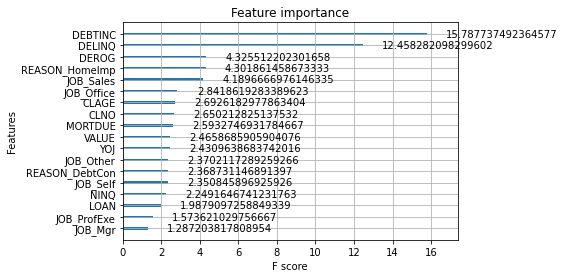

In [16]:
## Feature Importance
#ekstraks nama kolom setelah prepos
onehot_columns=model_best.best_estimator_.named_steps['prepo'].named_transformers_['categoric'].named_steps['onehot'].get_feature_names(input_features=cat_columns)
cols=np.array(list(num_columns)+list(onehot_columns))

#plot dengan nama kolom asli
model_best.best_estimator_.named_steps['algo'].get_booster().feature_names=list(cols)
plot_importance(model_best.best_estimator_.named_steps['algo'], importance_type='gain')

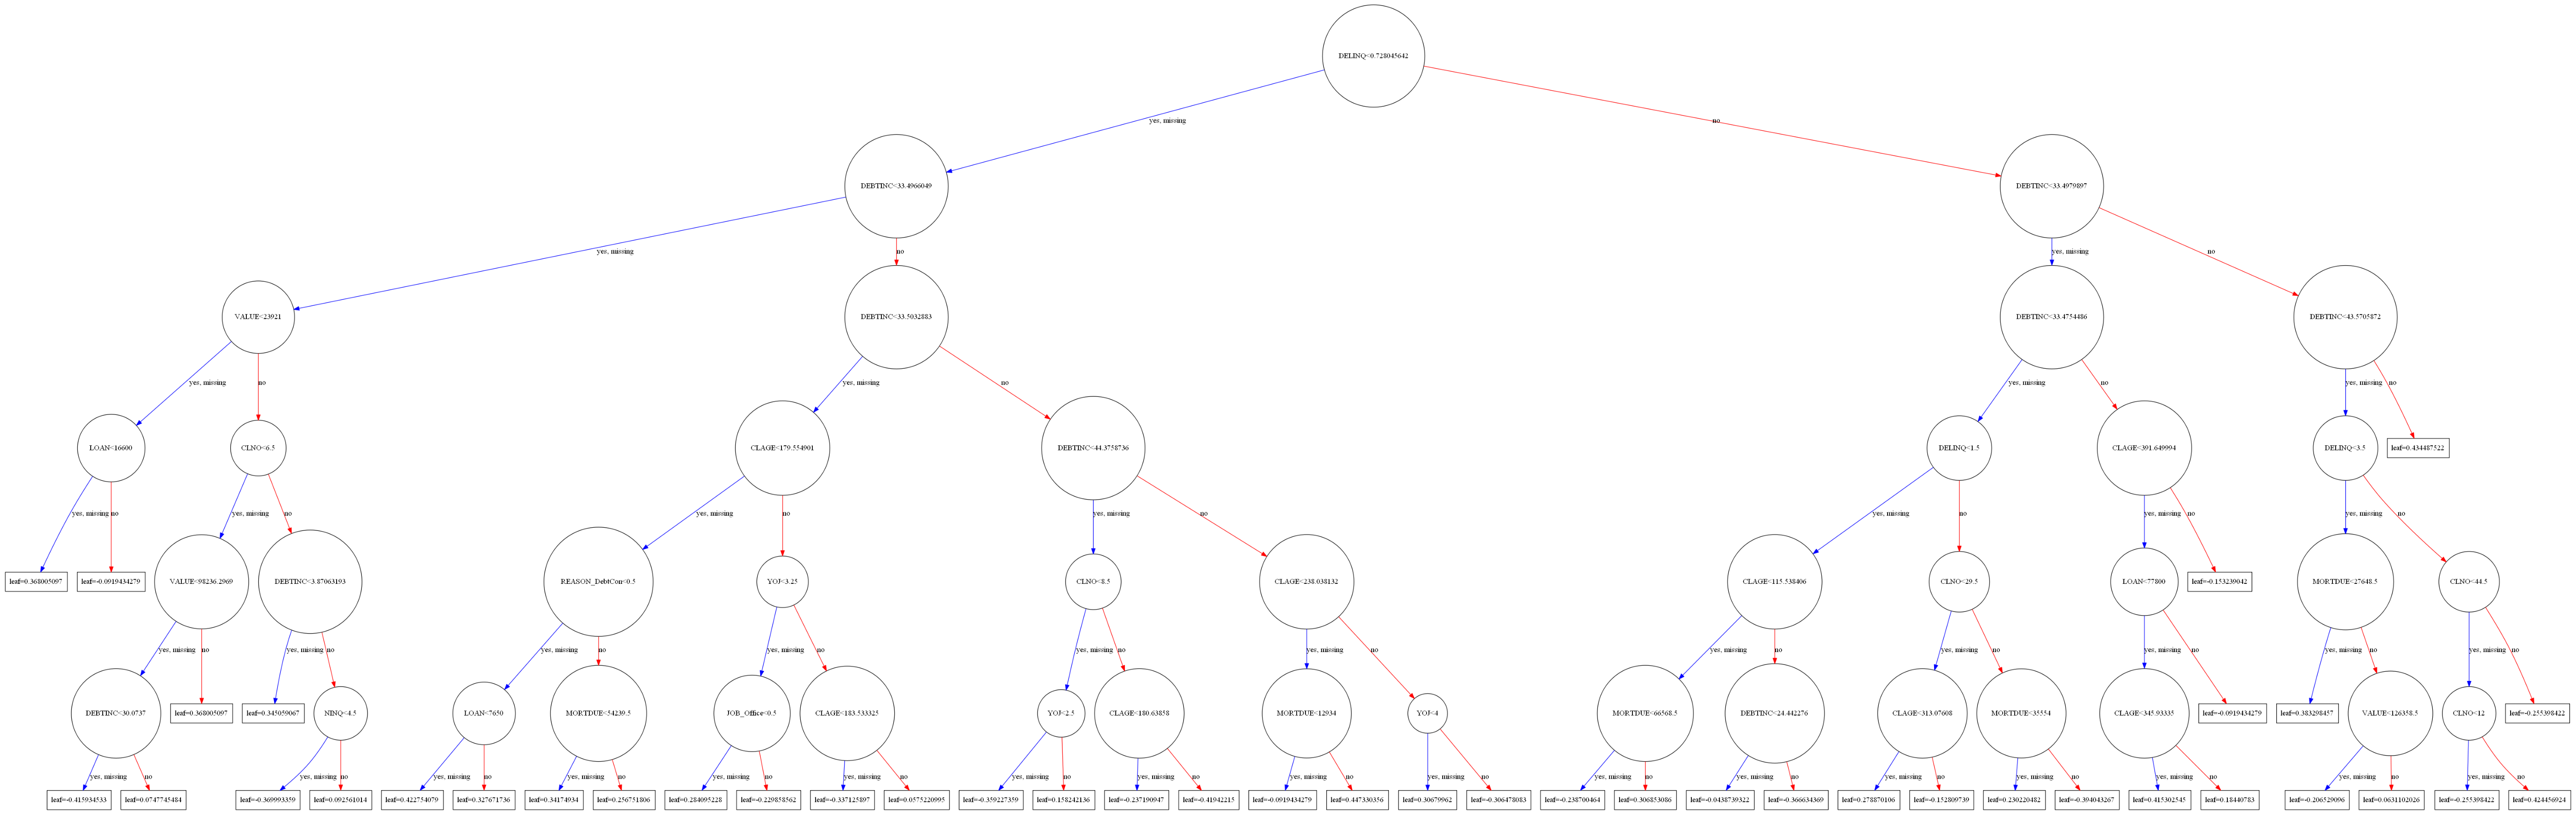

In [22]:
plot_tree(model_best.best_estimator_.named_steps['algo'])
fig=plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(100,100)
plt.savefig('newhmeqfix2305.pdf')

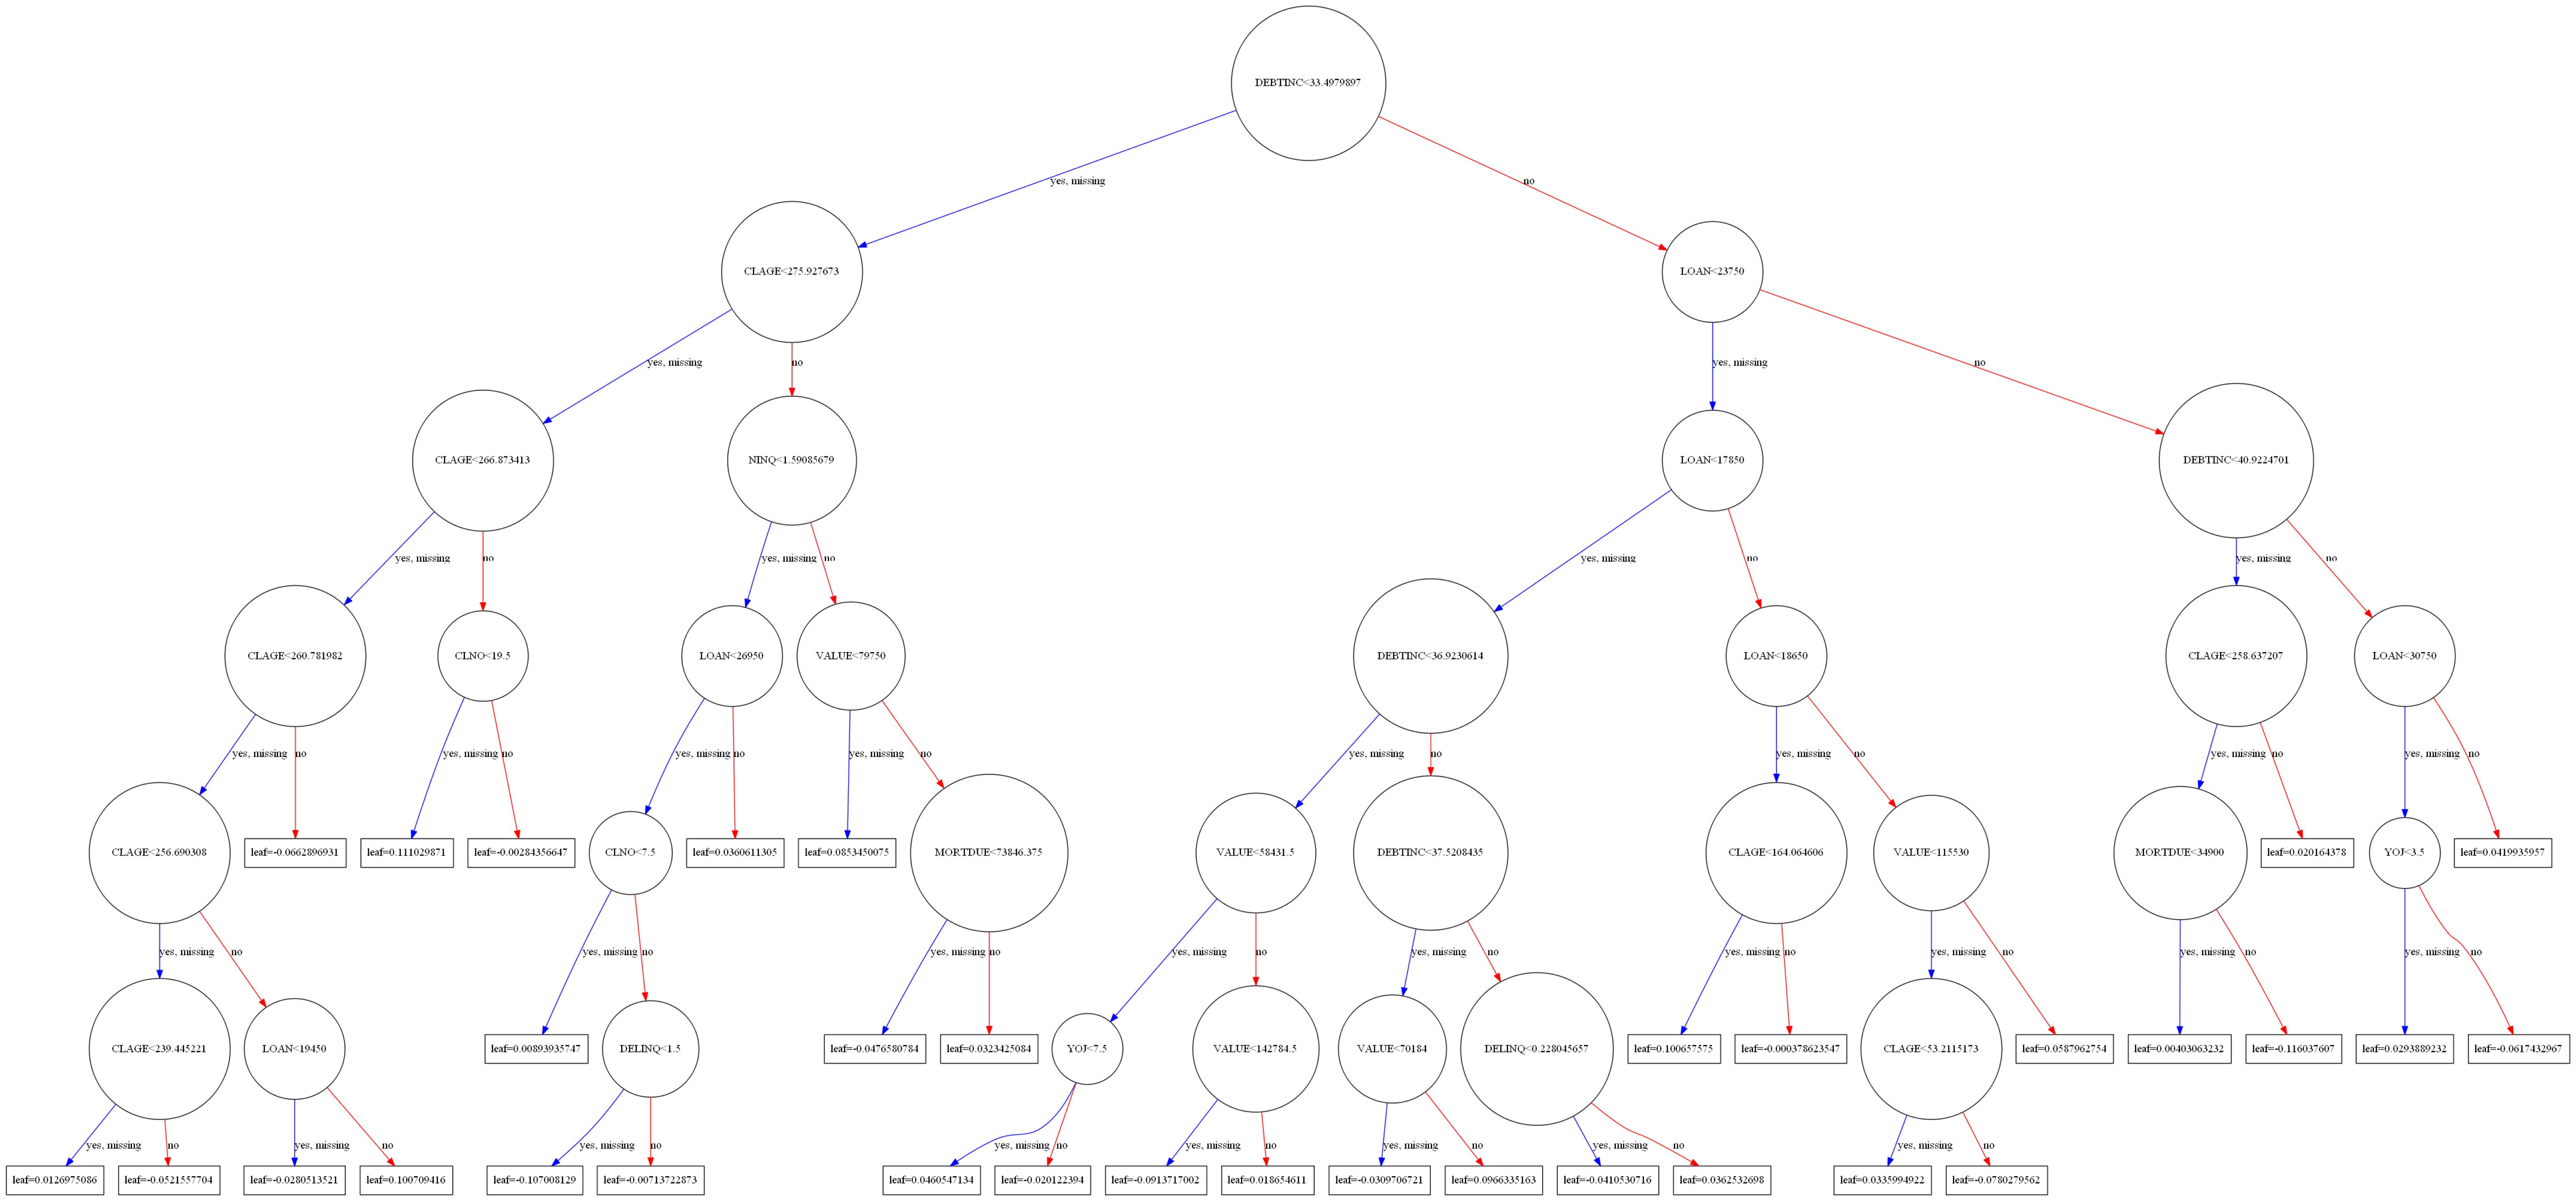

In [23]:
plot_tree(model_best.best_estimator_.named_steps['algo'], num_trees=173)
fig=plt.gcf()
plt.xticks(rotation=90)
fig.set_size_inches(100,100)
plt.savefig('newhmeqfix174_2305.pdf')

# Selesai, Alhamdulillah